In [451]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket
from datetime import datetime
import numpy as np
import scipy
import matplotlib.pyplot as plt
from qibo import hamiltonians

## Theoretical check

$$
H\otimes H e^{it Z\otimes Z}H\otimes H = X\otimes X ?
$$

Constructing a XX unitary and compare with one with ZZ.

In [395]:
# obtain e^{itX\otimes X} unitary
# Define the Pauli-X matrix
import scipy.linalg


X = np.array([[0, 1],
              [1, 0]], dtype=complex)

# Compute the tensor product X ⊗ X
XX = np.kron(X, X)

# Define the parameter t
t = np.pi / 6  # You can choose any real value for t

# Compute the unitary matrix U = e^{i t X⊗X}
U1 = scipy.linalg.expm(1j * t * XX)


In [396]:
# define the tensor hadamard unitary
H = 1/np.sqrt(2) * np.array([[1,1],
                             [1,-1]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)
HH = np.kron(H, H)
ZZ = np.kron(Z, Z)
U2 = HH @ scipy.linalg.expm(1j * t * ZZ) @ HH

In [397]:
np.linalg.norm(U1-U2)

9.496780065728157e-16

## Circuit implementation

From the above test, we see that theoretically, the decomposition is correct. Now we will build the pytket circuit for this decomposition.

According to the documentation: https://docs.quantinuum.com/h-series/trainings/getting_started/pytket_quantinuum/Quantinuum_arbitrary_angle_zz.html, the arbitrary angle ZZ gate in pytket is defined as
$$
RZZ(\alpha) = e^{-i\frac{\alpha}{2}Z\otimes Z}
$$

However, it is actually
$$
RZZ(\alpha) = e^{-i\frac{\alpha\pi}{2}Z\otimes Z}
$$

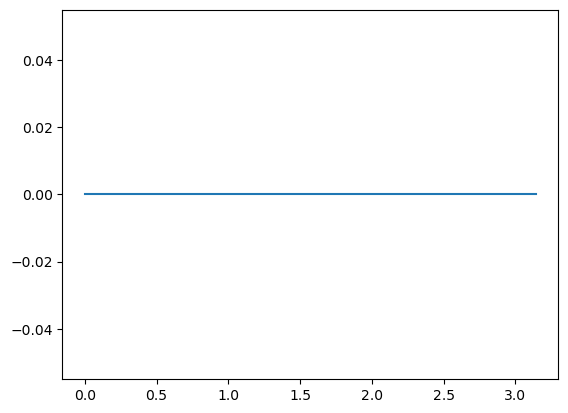

In [398]:
## RZZ in pytket
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    ZZ_evol = scipy.linalg.expm(1j * t * ZZ)
    c = Circuit(2)
    c.ZZPhase(-t*2/np.pi, 0, 1)
    diff.append(np.linalg.norm(ZZ_evol-c.get_unitary()))
    
plt.plot(t_range, diff)
    

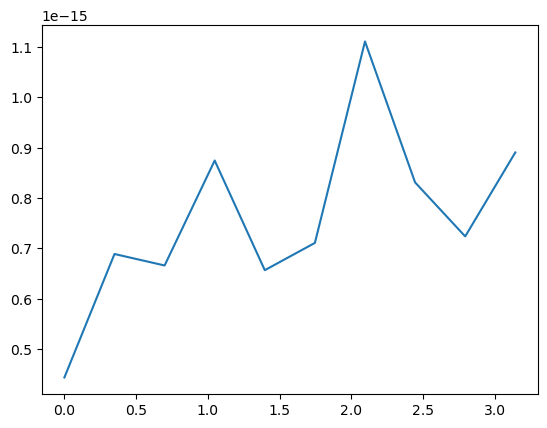

In [399]:
# compare our target circuit
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    U1 = scipy.linalg.expm(1j * t * XX)
    circuit1 = Circuit(2)
    circuit1.H(0)
    circuit1.H(1)
    circuit1.ZZPhase(-t*2/np.pi, 0, 1)
    circuit1.H(0)
    circuit1.H(1)
    U2 = circuit1.get_unitary()
    diff.append(np.linalg.norm(U1-U2))
plt.plot(t_range, diff)

## XXZ model

Now we will use native gates to simulate the XXZ hamiltonian given by
$$
H_ = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

Let's first consider the case with 2 qubit, since terms commute, the same strategy will apply to cases with more qubits.

Because the terms $X\otimes X$, $Y\otimes Y$, and $Z\otimes Z$ commute, we can write
$$
e^{it(XX+YY+ZZ)} = e^{itXX}e^{itYY}e^{itZZ}
$$

Then we have
$$
e^{itXX}=H\otimes H e^{itZZ}
$$
$$
e^{itYY}=(S\otimes S)(H\otimes H) e^{itZZ}(H\otimes H)(S^\dag\otimes S^\dag)
$$

Note that qibo.hamiltonians.XXZ for 2 qubits, there is an extra factor 2, that is QIBO_XXZ = 2 * XXZ.


Constructing an open boundary condition XXZ model (qibo XXZ uses periodic boundary condition)

In [429]:
def pauli_matrix(name):
    """Returns the Pauli matrix corresponding to the given name."""
    if name == 'I':
        return np.array([[1, 0], [0, 1]], dtype=complex)
    elif name == 'X':
        return np.array([[0, 1], [1, 0]], dtype=complex)
    elif name == 'Y':
        return np.array([[0, -1j], [1j, 0]], dtype=complex)
    elif name == 'Z':
        return np.array([[1, 0], [0, -1]], dtype=complex)
    else:
        raise ValueError("Invalid Pauli matrix name.")

def tensor(*args):
    """Computes the tensor product of multiple matrices."""
    result = args[0]
    for mat in args[1:]:
        result = np.kron(result, mat)
    return result

def construct_XXZ(nqubits=3, delta=0.5, boundary='open'):
    """Constructs the XXZ Hamiltonian for a given number of qubits and delta."""
    if boundary == 'periodic':
        return hamiltonians.XXZ(nqubits, delta).matrix
    elif boundary == 'open':
        # Initialize Hamiltonian to zero matrix
        dim = 2 ** nqubits
        H = np.zeros((dim, dim), dtype=complex)
        
        # Define Pauli matrices
        I = pauli_matrix('I')
        X = pauli_matrix('X')
        Y = pauli_matrix('Y')
        Z = pauli_matrix('Z')
        
        # Define interactions for nearest neighbors
        for i in range(nqubits -1):
            operators_xx = []
            operators_yy = []
            operators_zz = []
            for q in range(nqubits):
                if q == i or q == i+1:
                    operators_xx.append(X)
                    operators_yy.append(Y)
                    operators_zz.append(Z)
                else:
                    operators_xx.append(I)
                    operators_yy.append(I)
                    operators_zz.append(I)
            # Tensor products
            H += tensor(*operators_xx)
            H += tensor(*operators_yy)
            H += delta * tensor(*operators_zz)
        
        return H
    else:
        raise ValueError("Unsupported boundary condition, use either 'open' or 'periodic'. ")

# Construct the Hamiltonian
delta = 0.5
H = construct_XXZ(nqubits=2, delta=delta)

# Display the Hamiltonian matrix
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian Matrix (XXZ model for 3 qubits, delta=0.5):\n")
print(H)

Hamiltonian Matrix (XXZ model for 3 qubits, delta=0.5):

[[ 0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  2. +0.j  0. +0.j]
 [ 0. +0.j  2. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.5+0.j]]


### Simple check of ground state degeneracy

In [430]:
def check_ground_state_degeneracy(H, tol=1e-8):
    """
    Compute the eigenenergies of a Hamiltonian matrix and determine
    whether the ground state is degenerate.
    
    Parameters:
        H (numpy.ndarray): The Hamiltonian matrix (must be Hermitian).
        tol (float): Tolerance for considering eigenvalues as equal.
    
    Returns:
        eigenvalues_sorted (numpy.ndarray): Sorted eigenenergies in ascending order.
        is_degenerate (bool): True if the ground state is degenerate, False otherwise.
        ground_state_energy (float): The ground state energy.
        degeneracy (int): The number of degenerate ground states.
    """
    # Ensure H is a numpy array
    H = np.array(H)
    
    # Check if H is square
    if H.shape[0] != H.shape[1]:
        raise ValueError("Hamiltonian matrix must be square.")
    
    # Check if H is Hermitian
    if not np.allclose(H, H.conj().T, atol=tol):
        raise ValueError("Hamiltonian matrix must be Hermitian.")
    
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)
    
    # Sort eigenvalues in ascending order
    eigenvalues_sorted = np.sort(eigenvalues)
    
    # Ground state energy
    ground_state_energy = eigenvalues_sorted[0]
    
    # Find how many eigenvalues are equal to ground_state_energy within tolerance
    degenerate_indices = np.where(np.abs(eigenvalues_sorted - ground_state_energy) < tol)[0]
    degeneracy = len(degenerate_indices)
    
    is_degenerate = degeneracy > 1
    
    return eigenvalues_sorted, is_degenerate, ground_state_energy, degeneracy

In [434]:
# odd or even number of qubits have degenerate ground state?
H_even = construct_XXZ(nqubits=4, delta=0.5, boundary='open')
H_odd = construct_XXZ(nqubits=5, delta=0.5, boundary='open')


# Use the function on the manual Hamiltonian
eigenvalues, is_deg, gs_energy, deg = check_ground_state_degeneracy(H_even)

print("Eigenenergies (sorted):\n", eigenvalues)
print("\nGround State Energy:", gs_energy)
print("Is Ground State Degenerate?", is_deg)
print("Ground State Degeneracy:", deg)

Eigenenergies (sorted):
 [-5.42 -3.5  -3.5  -2.74 -1.06 -1.06 -0.5   0.28  1.5   1.5   1.5   1.5
  1.74  3.06  3.06  3.64]

Ground State Energy: -5.424343992020248
Is Ground State Degenerate? False
Ground State Degeneracy: 1


### Construct 2 qubit XXZ

In [401]:
t = np.pi/6
U1 = scipy.linalg.expm(-1j*t*H)

In [402]:
qc = Circuit(2)
# implement xx
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)

# implement yy
qc.Sdg(0), qc.Sdg(1)
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)
qc.S(0), qc.S(1)

# implement zz
qc.ZZPhase(-t*2/np.pi * delta, 0, 1)
U2 = qc.get_unitary()

In [403]:
render_circuit_jupyter(qc)

In [404]:
np.linalg.norm(U1-U2)

2.5035872647924866

## Check for n qubits XXZ

In this section, we check that the product formula converges to n qubit XXZ model evolution with Trotter-Suzuki formula.
To do this, we divide the interaction into odd and even sub-lattices.
i.e. [1,2], [3,4], [5,6] being `c_odd` and [2,3], [4,5] being `c_even`.
This way, we can run the non-interacting pairs simultaneously.


In [405]:
def XX_interaction(qc, q0, q1, t):
    qc.H(q0), qc.H(q1)
    qc.ZZPhase(-t*2/np.pi, q0, q1)
    qc.H(q0), qc.H(q1)

def YY_interaction(qc, q0, q1, t):
    qc.Sdg(q0), qc.Sdg(q1)
    XX_interaction(qc, q0, q1, t)
    qc.S(q0), qc.S(q1)

def ZZ_interaction(qc, q0, q1, t):
    qc.ZZPhase(-t*2/np.pi, q0, q1)

We consider 2 ways of decomposing the XXZ terms:
1. 2 layers:
2. 3 layers

In [438]:
def XXZ_decomposition(nqubits, t, delta=0.5, qc=None, layer=2, boundary='open'):
    # This function generates the circuit that simulates e^{itH}
    # where H is the XXZ model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        if boundary == 'periodic' or 'closed':
            if nqubits % 2 == 0:
                # even number of qubits add to odd pairs
                odd_starting_pairs.append([0, nqubits-1])
            else:
                even_starting_pairs.append([0, nqubits-1])
                # note that odd number of qubits result in degenerate ground states
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    if layer == 2:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
    elif layer == 3:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
    else:
        raise ValueError("Number of layers not supported, use either '2' or '3'.")
    return qc

Double check whether the tensor product approach gives the same unitary as QIBO model.

In [437]:
H_qibo = hamiltonians.XXZ(8, 0.5).matrix
H_tensor = construct_XXZ(8, 0.5, 'periodic')
print(np.linalg.norm(H_qibo - H_tensor))

0.0


Let's first fix the time and evaluate the error as we increase the number of qubits.

In [440]:
test_qubits = [2,3,4,5,6,7,8,9,10]
t = np.pi/6
U1 = [scipy.linalg.expm(1j*t*(construct_XXZ(n,delta))) for n in test_qubits]
U2 = [XXZ_decomposition(n, t, delta).get_unitary() for n in test_qubits]
U3 = [XXZ_decomposition(n, t, delta, layer=3).get_unitary() for n in test_qubits]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_qubits))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_qubits))]

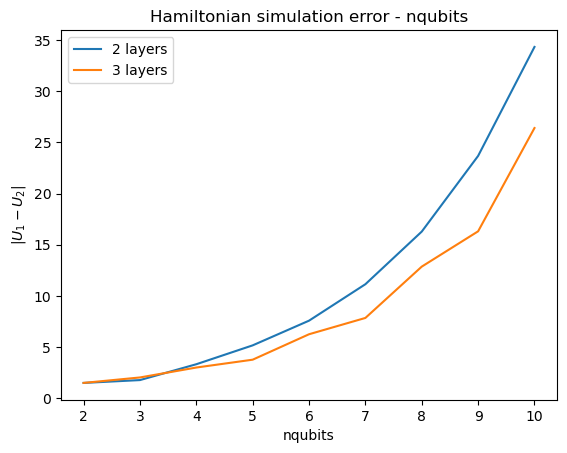

In [442]:
plt.plot(test_qubits, diff_12, label='2 layers')
plt.plot(test_qubits, diff_13, label='3 layers')
plt.xlabel('nqubits')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - nqubits')
plt.legend()

Now we fix nqubits and vary time.

In [463]:
nqubits = 5
test_t = np.linspace(0, np.pi/2, 30)
U1 = [scipy.linalg.expm(1j*t*(construct_XXZ(nqubits,delta))) for t in test_t]
U2 = [XXZ_decomposition(nqubits, t, delta).get_unitary() for t in test_t]
U3 = [XXZ_decomposition(nqubits, t, delta, layer=3).get_unitary() for t in test_t]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_t))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_t))]

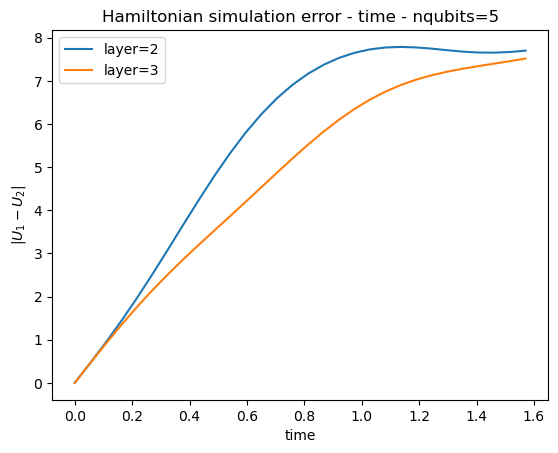

In [464]:
plt.plot(test_t, diff_12, label='layer=2')
plt.plot(test_t, diff_13, label='layer=3')
# plt.yscale('log')
plt.xlabel('time')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - time - nqubits=5')
plt.legend()

Next, we see how trotterization reduces the error when we fix the time.

In [466]:
t = np.pi/20
nqubits = 5
n_trotter = 10
U1 = scipy.linalg.expm(1j*t*(construct_XXZ(nqubits, delta)))

In [467]:
def trotter_circuit(nqubits, t, n_trotter, layer=2):
    qc = Circuit(nqubits)
    dt = t/n_trotter
    for n in range(n_trotter):
        qc = XXZ_decomposition(nqubits, dt, delta, qc, layer=layer)
    return qc

In [468]:
U2 = [trotter_circuit(nqubits, t, n).get_unitary() for n in range(1, n_trotter)]
U3 = [trotter_circuit(nqubits, t, n, layer=3).get_unitary() for n in range(1, n_trotter)]
diff_12 = [np.linalg.norm(U1-U2[i]) for i in range(n_trotter-1)]
diff_13 = [np.linalg.norm(U1-U3[i]) for i in range(n_trotter-1)]

Text(0.5, 1.0, 'Hamiltonian simulation error - trotter steps')

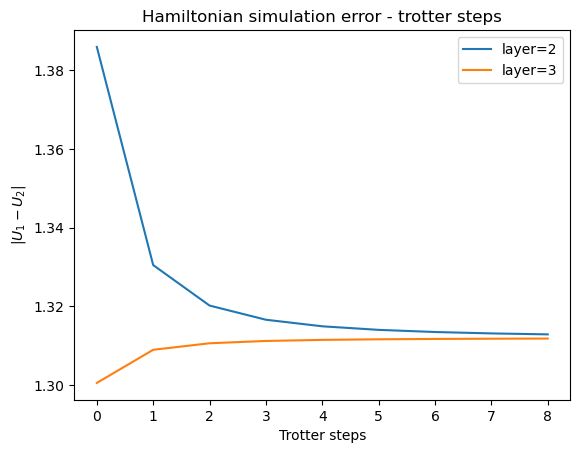

In [469]:
plt.plot(diff_12, label='layer=2')
plt.plot(diff_13, label='layer=3')
plt.legend()
plt.xlabel('Trotter steps')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - trotter steps')

## One step of DBQA

Now we have seen that using S, H, and ZZ gates, we are able to simulate the XXZ hamiltonian.

Recall that a double-bracket-rotation is given by

$$
H_{k+1} = e^{s_kW_k}H_ke^{-s_kW_k}
$$

where $s$ is the rotation duration, the rotation generator $W_k:=[D_k, H_k]$, and $D_k$ is a diagonal operator. 

The reduced group commutator is given by
$$P_k = e^{is D_k} e^{is H_k} e^{-isD_k}$$

$$V_1 = e^{-iD}U_\theta^\dag e^{-itH}U_\theta e^{iD}$$

$$U_1 = U_\theta * V_1$$

$$ |\psi_1(\theta)\rang = U_1|0\rang$$

After dropping a global phase,

$$ |\psi_1(\theta)\rang = U_\theta e^{-iD}U_\theta^\dag e^{-itH}U_\theta|0\rang$$

We use 8 qubits as an example.
1. Train VQE circuit get unitary
2. Train GCI get a good D operator
3. Get the expectation of U1

In [453]:
# Load the VQE circuit
optimizer = 'sgd'
nqubits = 8
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
V = vqe_circ.get_unitary()

# Execution on Quantinuum

# 